## Jam's heatmaps
The goal of this notebook is to create heatmaps with the mean number of jams per day in a Baghdad for May 2024. Three heatmaps are calcualted for: Monday-Tuesday and Wednesday (mid-week), Sunday and Thursday(ext-week) and Friday and Saturday(weekend). 
The process does not take place entirely on this notebook, part of it occurs on a R script to take advantage of some of the packages available there. The steps are the following:
1. Read the data and repartition it by date and group of days (mid-week, ext-week, weekend)
2. Rasterize each vector file using the same raster as a base
3. Calculate the mean number of jams for each pixel

### Step 1. Read and re-partition the data
In this step, we read the data and re-partition it by date. The goal is to obtain only the data for the month of May 2024

In [1]:
import pandas as pd
import yaml
from datetime import datetime
from wazeasy import utils
import dask.dataframe as dd

In [3]:
storage_options = {'profile': 's3_ddp_dec'
                  }

In [ ]:
path = 's3://wbg-waze/bq/IQ/595baghdad/jams/IQ_595baghdad_jams.*.parquet'
ddf = dd.read_parquet(path, storage_options = storage_options, engine = 'pyarrow', columns = ['ts', 'level','geoWKT'])

In [5]:
utils.handle_time(ddf, 'Asia/Baghdad', parquet = True)

In [6]:
ddf = utils.remove_level5(ddf)

In [7]:
ddf_filtered = ddf[(ddf['year']==2024)&(ddf['month']==5)]

In [8]:
ddf_filtered['dow'] = ddf_filtered['local_time'].dt.dayofweek

In [9]:
groups = {0: 'Mon-Tues-Wed',
          1: 'Mon-Tues-Wed',
          2: 'Mon-Tues-Wed',
          3: 'Sun-Thu',
          4: 'Fri-Sat',
          5: 'Fri-Sat',
          6: 'Sun-Thu'}
ddf_filtered['group'] = ddf_filtered['dow'].map(groups)

In [10]:
ddf_filtered['date'] = ddf_filtered['date'].astype('datetime64[ns]')

In [11]:
ddf_mid_week = ddf_filtered[ddf_filtered['group']=='Mon-Tues-Wed'][['geoWKT', 'date']]
ddf_ext_week = ddf_filtered[ddf_filtered['group']=='Sun-Thu'][['geoWKT', 'date']]
ddf_weekend = ddf_filtered[ddf_filtered['group']=='Fri-Sat'][['geoWKT', 'date']]

In [12]:
ddf_mid_week.to_parquet(
            'ddf_mid_week',
            append=False,
            ignore_divisions=False,
            compression="snappy",
            engine="pyarrow",
            write_index = False, 
            partition_on=["date"],
        )

ddf_ext_week.to_parquet(
            'ddf_ext_week',
            append=False,
            ignore_divisions=False,
            compression="snappy",
            engine="pyarrow",
            write_index = False, 
            partition_on=["date"],
        )

ddf_weekend.to_parquet(
            'ddf_weekend',
            append=False,
            ignore_divisions=False,
            compression="snappy",
            engine="pyarrow",
            write_index = False, 
            partition_on=["date"],
        )

### Step 2. Rasterize the vector layer
This step is produced in the script fasterize.R. It creates a reaster layer by counting the number of jams that were seen on each pixel of the area of interest.  

### Step 3. Calculate the mean number of jams per day
Once we have the raster with the number of jams per pixel for each day in the month of May 2024, we calculate, for each group of days of the week, the mean number of jams in each pixel. As a result, we obtain the three maps from below. The GeoTiff version can be found [here](https://worldbankgroup.sharepoint.com/:f:/r/teams/DevelopmentDataPartnershipCommunity-WBGroup/Shared%20Documents/Projects/Data%20Lab/Baghdad%20Transportation%20Planning/Data/rasters?csf=1&web=1&e=CFwvhs)

In [2]:
import rasterio
import numpy as np
import os 

In [3]:
path = '/home/sol/gitrepo/iraq-baghdad-transport-planning/results/rasters/'
group = 'weekend'
files = os.listdir(path + group + '/') 

In [5]:
array_list = []
for file in files:
    dataset = rasterio.open(path + group + '/' + file)
    data = dataset.read(1)
    new_data = np.where(data < 0, 0, data)
    array_list.append(new_data)
stacked_arrays = np.stack(array_list, axis = 0)
mean_array = np.mean(stacked_arrays, axis = 0)

In [6]:
mean_dataset = rasterio.open(
                            path + 'means/' + f'mean_njams_{group}.tif',
                            'w',
                            driver = 'GTiff',
                            height = dataset.shape[0],
                            width = dataset.shape[1],
                            count = 1,
                            dtype = type(new_data[0][0]),
                            crs = dataset.crs,
                            transform = dataset.transform
                        )
mean_dataset.write(mean_array, 1)
mean_dataset.close()

In [1]:
import rasterio
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
import numpy as np

In [2]:
path = '/home/sol/gitrepo/iraq-baghdad-transport-planning/results/rasters/means/'

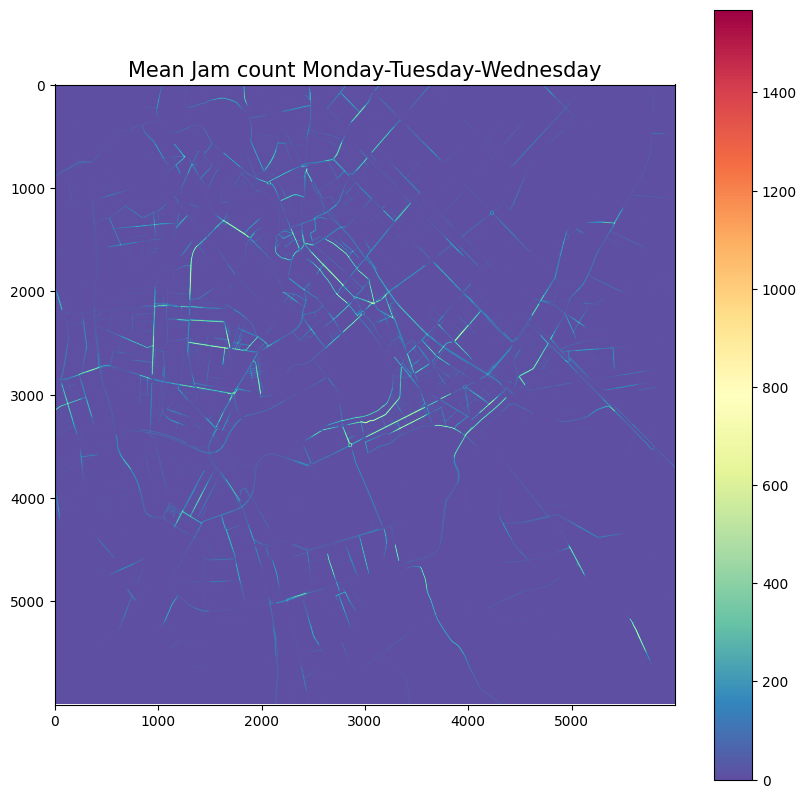

In [3]:
file = 'mean_njams_mid_week.tif'
dataset = rasterio.open(path + file)
data = dataset.read(1)
fig, ax = plt.subplots(figsize=(10, 10))
img = ax.imshow(data[4000:10000,3000:9000], cmap = 'Spectral_r')
plt.colorbar(img)
ax.set_title('Mean Jam count Monday-Tuesday-Wednesday', fontsize=15);

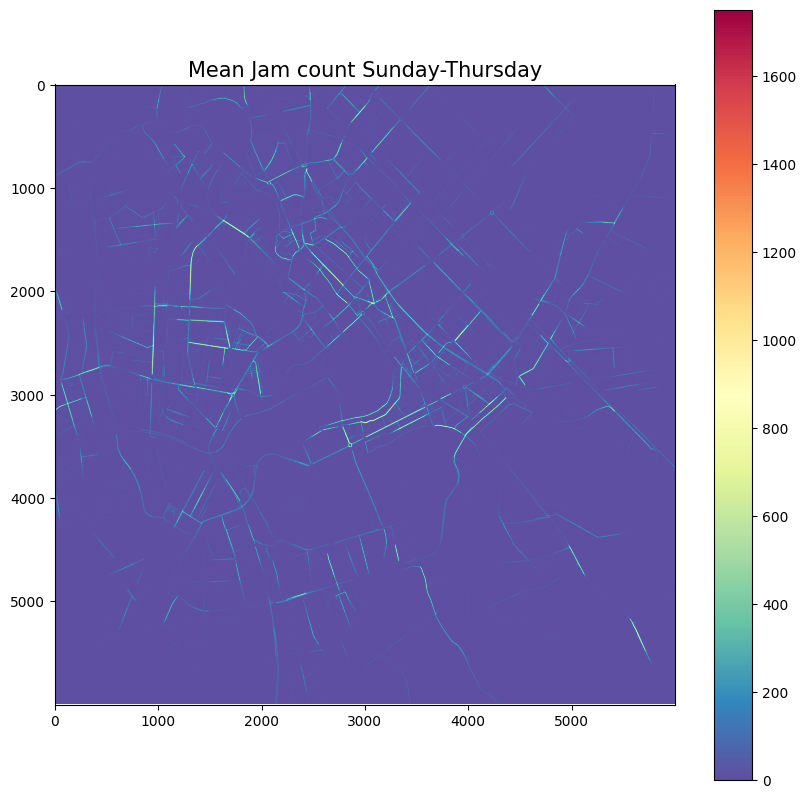

In [4]:
file = 'mean_njams_ext_week.tif'
dataset = rasterio.open(path + file)
data = dataset.read(1)
fig, ax = plt.subplots(figsize=(10, 10))
img = ax.imshow(data[4000:10000,3000:9000], cmap = 'Spectral_r')
plt.colorbar(img)
ax.set_title('Mean Jam count Sunday-Thursday', fontsize=15);

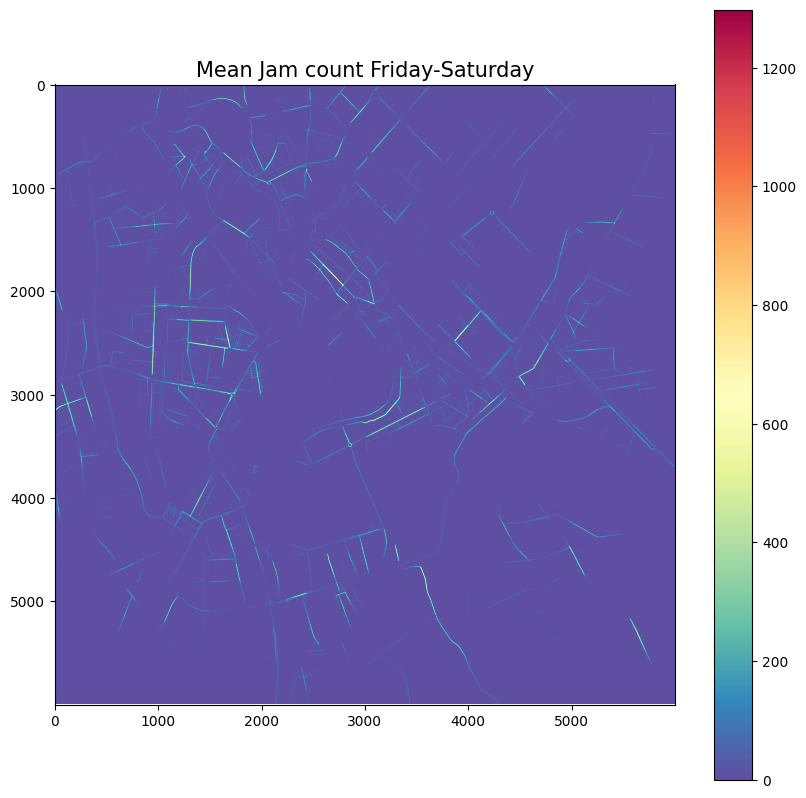

In [5]:
file = 'mean_njams_weekend.tif'
dataset = rasterio.open(path + file)
data = dataset.read(1)
fig, ax = plt.subplots(figsize=(10, 10))
img = ax.imshow(data[4000:10000,3000:9000], cmap = 'Spectral_r')
plt.colorbar(img)
ax.set_title('Mean Jam count Friday-Saturday', fontsize=15);